# A4C Model Training

This code runs A4C model training in two steps. The first step uses watershed labels generated in previous steps. The second step uses labels generated by the first step model (self-learning).

Inputs: 
- A4C images (in .npy format)
- Quality controlled A4C watershed labels
- Self learning labels (in .npy format)

Outputs:
- 1st round A4C Model from labels generated by A2C model
- 2nd round A4C Model from self-learning labels

Workflow Steps
1. Import necessary libraries and modules.
2. Load the A4C images and quality controlled A4C labels from A2C model.
3. Create a data generator for training and validation data.
4. Define the model architecture for the 1st round A4C model.
5. Train the 1st round A4C model using the data generator.
6. Save the trained 1st round A4C model.
7. Generate & load the self-learning labels.
8. Create a new data generator for self-learning data.
9. Define the model architecture for the 2nd round A4C model.
10. Train the 2nd round A4C model using the self-learning data.
11. Save the trained 2nd round A4C model.
12. Run model on training data to see final labels.

<span style="color:red">*Note: The cell that generates self-learning labels is commented out, because the model trained from our small example dataset cannot provide viable labels. Uncomment it after supplying more data.*</span>

In [1]:
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

from utils import util_train, util_seg
from model_arch import unet

Using TensorFlow backend.
2024-08-13 23:47:30.529509: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2024-08-13 23:47:30.529579: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2024-08-13 23:47:30.529585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Load Unet model

In [3]:
HEIGHT = 256
WIDTH = 256

modela4c = unet.get_unet(HEIGHT, WIDTH, img_ch=3, ch=5)

2024-08-13 23:47:32.076788: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-08-13 23:47:32.076822: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-13 23:47:32.076839: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-13-133.us-west-1.compute.internal): /proc/driver/nvidia/version does not exist
2024-08-13 23:47:32.077033: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-08-13 23:47:32.083067: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2024-08-13 23:47:32.083607: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559ab8f95f10 initialized for platform Ho

## Load dataframe of images names

In [4]:
image_names = pd.read_csv('example_data/A4C/a4c_step1_labels_passed_qc.csv')['Image'].values.tolist()

# Randomly take 80% of the data for training and 20% for validation
random.shuffle(image_names)
X_train = image_names[:int(len(image_names)*0.8)]
X_val = image_names[int(len(image_names)*0.8):]

size_of_training = len(X_train)
size_of_validation = len(X_val)

print(f"Size of training: {size_of_training}")
print(f"Size of validation: {size_of_validation}")

Size of training: 8
Size of validation: 2


In [5]:
HEIGHT = 256
WIDTH = 256
KERNEL = (3,3)
BATCH_SIZE = 64
N_CHANNELS = 5

## Load Data Generator

In [6]:
train_DataGenerator = util_train.DataGenerator(
    list_IDs=X_train,
    labels=X_train,
    path_img='example_data/A4C/a4c_images/',
    path_label='example_data/A4C/a4c_step1_labels_stretched_rv/',
    path_self_learning='example_data/A4C/a4c_step2_labels/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    augment=True,
    self_learning=False
    )
val_DataGenerator = util_train.DataGenerator(
    list_IDs=X_val,
    labels=X_val,
    path_img='example_data/A4C/a4c_images/',
    path_label='example_data/A4C/a4c_step1_labels_stretched_rv/',
    path_self_learning='example_data/A4C/a4c_step2_labels/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    augment=False,
    self_learning=False
    )

## Visualize DataGenerator

(64, 256, 256, 3) (64, 256, 256, 5) 1.0 1 float32 uint8
1.0 1


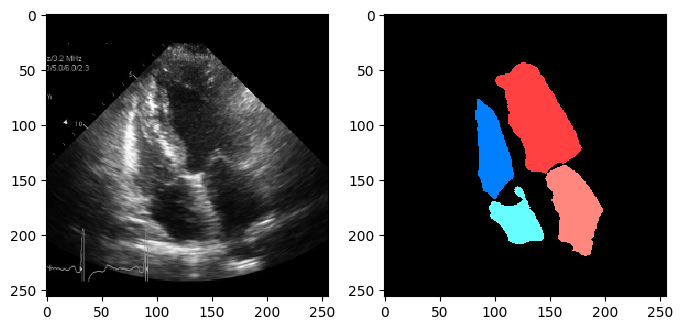

1.0 1


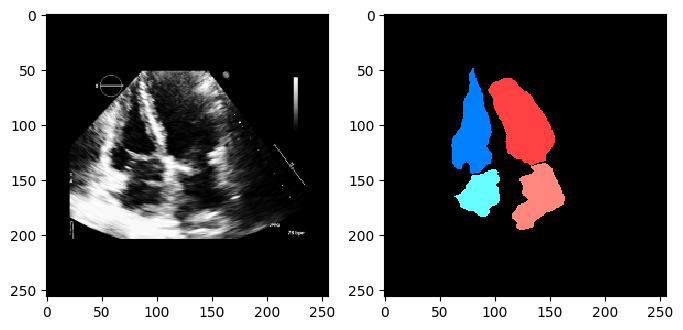

1.0 1


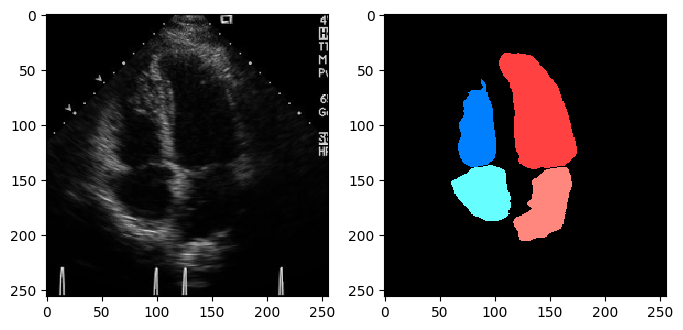

1.0 1


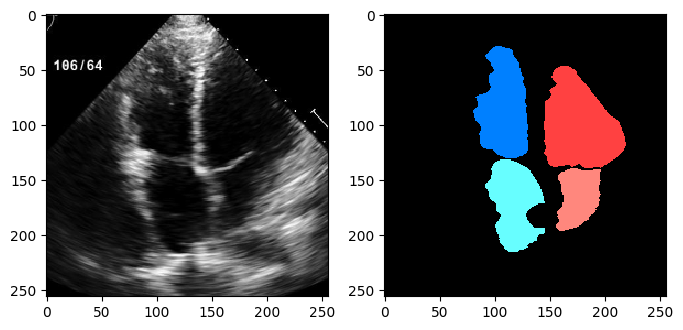

1.0 1


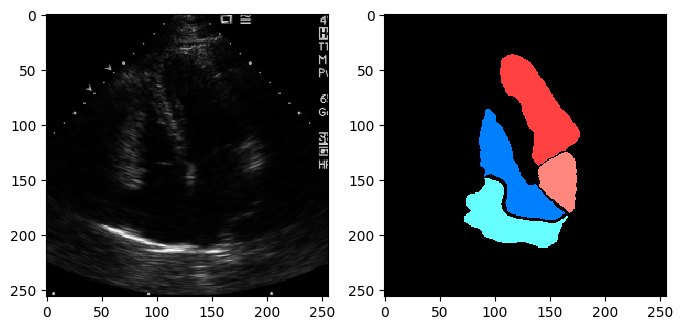

In [7]:
color_list_a4c = [(0,0,0), (255,135,125), (255,65,65), (103,254,255), (0,128,255)]

x, y = train_DataGenerator.__getitem__(0)
print(x.shape,y.shape,x.max(),y.max(), x.dtype,y.dtype)
for k in range(5):
    print(x[k].max(),y[k].max())
    
    img_rgb = util_seg.cat_to_color(y[k][np.newaxis].astype(int), color_list_a4c)

    plt.figure(figsize=[8,8])
    plt.subplot(121),plt.imshow(x[k,...,0][...], cmap='gray')
    plt.subplot(122),plt.imshow((img_rgb[0]).astype('uint8'), cmap = 'gray')
    plt.show()

In [8]:
path_w = 'example_model_checkpoints/A4C/1stRound_UNet_A4CModel_{epoch:02d}.h5'

LossHist = util_train.LossHistory()
checkpoint = ModelCheckpoint(path_w, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
EPOCHS = 5

hist = modela4c.fit_generator(generator = train_DataGenerator,
                              verbose=0,   # We have to disable prog bar because our validation set is so small, but you can remove this line when using more data to see training progress
                              steps_per_epoch = size_of_training//BATCH_SIZE,
                              validation_data = val_DataGenerator,
                              callbacks=[LossHist,checkpoint],
                              use_multiprocessing = False, 
                              validation_steps = max(1,size_of_validation//BATCH_SIZE), 
                              epochs=EPOCHS, 
                              shuffle=True,
                              workers=0)

In [9]:
# The code below plots loss history. Because our validation dataset is limited, we cannot show the calculated loss

# history=hist
# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['dice_coefficient'])
# # plt.plot(history.history['val_dice_coefficient'])
# plt.title('Dice score')
# plt.ylabel('dice')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# # plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['loss', 'val_loss'], loc='upper left')
# #plt.savefig('AE_denoising_4LS_A2C_G2G_sharp_mask_bifilter_pred.png')
# plt.show()

In [10]:
modela4c.save('example_models/A4C/1stRound_Unet_A4CModel_Example.h5')

In [11]:
# Because the a4c model that we just trained was trained on very little data, we use pre-generated labels for self training in this example, instead of generating as we would in the code below

# Generate the self learning labels
# path_img = 'example_data/A4C/a4c_images/'
# path_label = 'example_data/A4C/a4c_step2_labels/'
# for ID in image_names:
#     img_res = np.load(f'{path_img}{ID}')
#     label = util_seg.get_img_pred(modela4c, img_res, 'a4c')[0]
#     np.save(f'{path_label}{ID}', label)

In [12]:
train_DataGenerator = util_train.DataGenerator(
    list_IDs=X_train,
    labels=X_train,
    path_img='example_data/A4C/a4c_images/',
    path_label='example_data/A4C/a4c_step1_labels_stretched_rv/',
    path_self_learning='example_data/A4C/a4c_step2_labels/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    augment=True,
    model=modela4c,
    self_learning=True)

val_DataGenerator = util_train.DataGenerator(
    list_IDs=X_val,
    labels=X_val,
    path_img='example_data/A4C/a4c_images/',
    path_label='example_data/A4C/a4c_step1_labels_stretched_rv/',
    path_self_learning='example_data/A4C/a4c_step2_labels/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    augment=False,
    model=modela4c,
    self_learning=True)

(64, 256, 256, 3) (64, 256, 256, 5) 1.0 1 float32 uint8
1.0 1


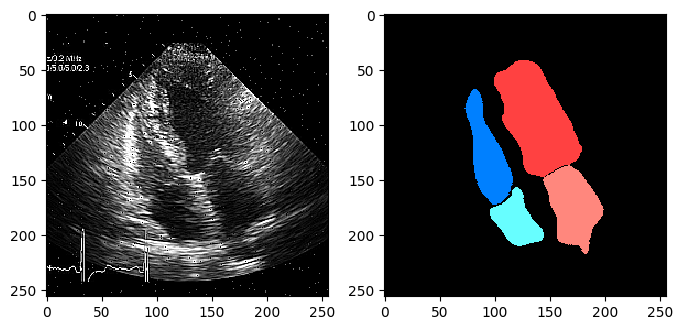

1.0 1


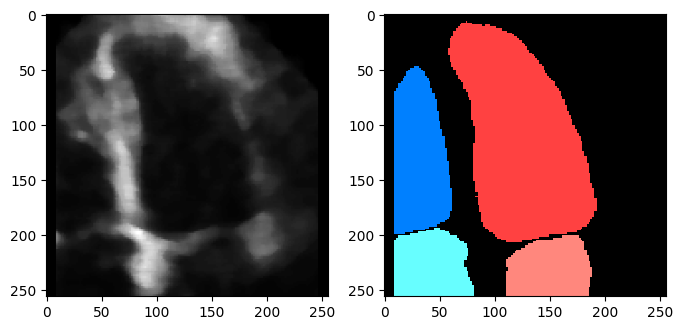

1.0 1


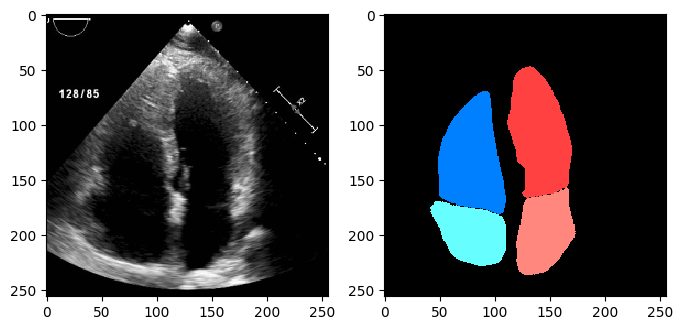

1.0 1


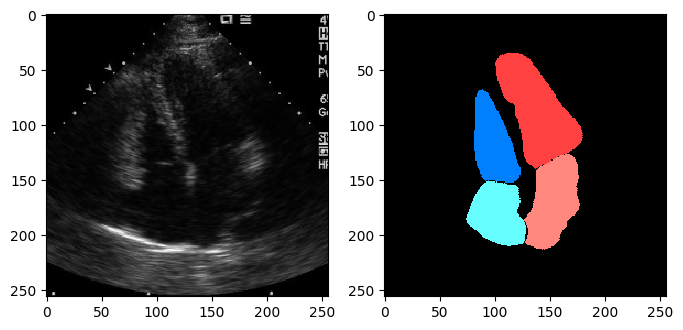

1.0 1


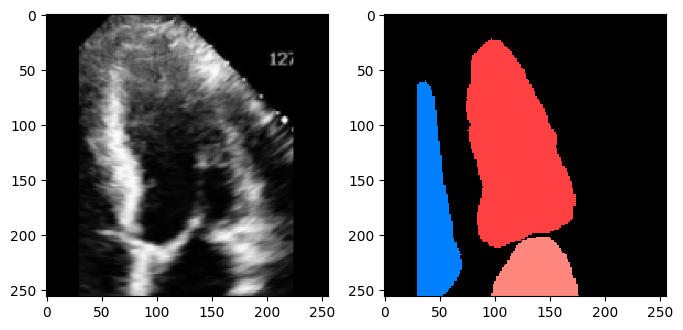

1.0 1


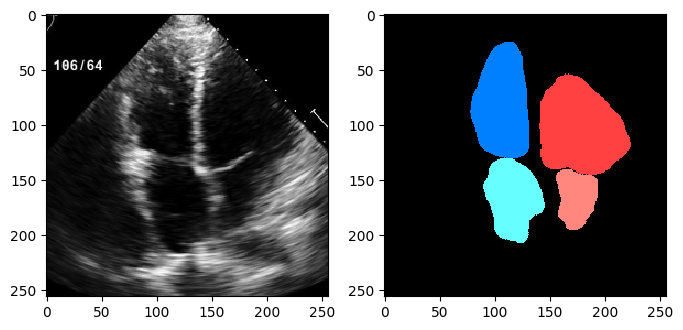

In [13]:
color_list_a4c = [(0,0,0), (255,135,125), (255,65,65), (103,254,255), (0,128,255)]

x, y = train_DataGenerator.__getitem__(0)
print(x.shape,y.shape,x.max(),y.max(), x.dtype,y.dtype)
nb_examples = 0
for k in range(len(x)):
    if nb_examples > 5:
        break

    print(x[k].max(),y[k].max())
    
    try:
        img_rgb = util_seg.cat_to_color(y[k][np.newaxis].astype(int), color_list_a4c)

        plt.figure(figsize=[8,8])
        plt.subplot(121),plt.imshow(x[k,...,0][...], cmap='gray')
        plt.subplot(122),plt.imshow((img_rgb[0]).astype('uint8'), cmap = 'gray')
        plt.show()

        nb_examples += 1
    except:
        continue

In [14]:
path_w = 'example_model_checkpoints/A4C/2ndRound_UNet_A4CModel_Self_learning{epoch:02d}.h5'

LossHist = util_train.LossHistory()
checkpoint = ModelCheckpoint(path_w, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
EPOCHS = 3

hist = modela4c.fit_generator(generator = train_DataGenerator,
                              verbose=0,   # We have to disable prog bar because our validation set is so small, but you can remove this line when using more data to see training progress
                              steps_per_epoch = size_of_training//BATCH_SIZE,
                              validation_data = val_DataGenerator,
                              callbacks=[LossHist,checkpoint],
                              use_multiprocessing = False, 
                              validation_steps = max(1,size_of_validation//BATCH_SIZE), 
                              epochs=EPOCHS, 
                              shuffle=True,
                              workers=0)


In [15]:
modela4c.save('example_models/A4C/2ndRound_Unet_A4CModel_Self_learning_Example.h5')

# Inference

In [16]:
# Because the a4c model that we just trained was trained on very little data, we use pre-generated labels for self training in this example

# Generate the self learning labels
# modela4c.load_weights('real_models/2ndRound_UNet_A4CModel_April2019_SelfLearning_MaskAug.h5')
# path_img = 'example_data/A4C/a4c_images/'
# path_label = 'example_data/A4C/a4c_final_inference/'
# if not os.path.exists(path_label):
#     os.makedirs(path_label)

# for ID in image_names:
#     img_res = np.load(f'{path_img}{ID}')
#     label = util_seg.get_img_pred(modela4c, img_res, 'a4c')[0]
#     np.save(f'{path_label}{ID}', label)